In [1]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from model_settings import ms
os.chdir(os.path.abspath(str(Path())))
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
notebook_dir = str(Path().resolve())
sys.path.append(os.path.join(notebook_dir,'historical_data','historical_generation'))
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")


##################
# training start #
##################

Sun Oct 27 08:04:37 2024



# Loading data

In [2]:
root = Path().resolve().parent.parent
datadir = os.path.join(root,ms.bloomberg_spx_asians['dump'])
files = [f for f in os.listdir(datadir) if f.endswith('.csv')]
files = [os.path.join(datadir,f) for f in files]
dfs = []
bar = tqdm(total=len(files)+1)
for f in files:
    dfs.append(pd.read_csv(f).iloc[:,1:])
    bar.update(1)
dataset = pd.concat(dfs,ignore_index=True).dropna().reset_index(drop=True)
bar.update(1)
bar.close()

100%|█████████████████████████████████████████████████████████████████████████████| 1511/1511 [00:01<00:00, 810.01it/s]


In [3]:
from quantlib_pricers import vanilla_pricer
vanillas = vanilla_pricer()
dataset['calculation_date'] = pd.to_datetime(dataset['calculation_date'],format='%Y-%m-%d')


initializing vanilla pricer
Actual/365 (Fixed) day counter
seed: 123



# Preprocessing

In [4]:
from convsklearn import asian_trainer, barrier_trainer
price = 'asian' 
filetag = 'asian options'
trainer = asian_trainer
trainer.activation_function = 'relu'
trainer.solver = 'sgd'
dataset[price] = pd.to_numeric(dataset[price],errors='coerce')
dataset['observed_price'] = np.maximum(dataset[price] + np.random.normal(scale=(0.15)**2,size=dataset.shape[0]),0)
dataset['calculation_date'] = pd.to_datetime(dataset['calculation_date'])
dataset = dataset.sort_values(by='calculation_date')
dataset = dataset.dropna().reset_index(drop=True)
dataset

,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,calculation_date,kappa,theta,rho,eta,v0,asian,observed_price
0,1416.59000,708.00000,7,7.00000,1,0,geometric,call,0.04000,0.01812,2007-01-03,0.23344,0.08296,-1.00000,0.09850,0.01066,708.56570,708.56009
1,1416.59000,1062.00000,336,2.00000,168,0,arithmetic,call,0.04000,0.01812,2007-01-03,0.23344,0.08296,-1.00000,0.09850,0.01066,355.61300,355.62111
2,1416.59000,1062.00000,336,2.00000,168,0,geometric,put,0.04000,0.01812,2007-01-03,0.23344,0.08296,-1.00000,0.09850,0.01066,0.02173,0.00517
3,1416.59000,1062.00000,336,2.00000,168,0,geometric,call,0.04000,0.01812,2007-01-03,0.23344,0.08296,-1.00000,0.09850,0.01066,353.74352,353.71212
4,1416.59000,708.00000,336,2.00000,168,0,arithmetic,put,0.04000,0.01812,2007-01-03,0.23344,0.08296,-1.00000,0.09850,0.01066,0.00000,0.01750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634195,1425.77000,1781.50000,168,168.00000,1,0,geometric,put,0.04000,0.02223,2012-12-31,0.89821,0.05621,-0.41897,0.32487,0.02466,338.84121,338.87220
634196,1425.77000,1781.50000,168,168.00000,1,0,geometric,call,0.04000,0.02223,2012-12-31,0.89821,0.05621,-0.41897,0.32487,0.02466,1.11486,1.10138
634197,1425.77000,1425.00000,168,168.00000,1,0,arithmetic,put,0.04000,0.02223,2012-12-31,0.89821,0.05621,-0.41897,0.32487,0.02466,57.72555,57.72876
634198,1425.77000,1781.50000,168,24.00000,7,0,arithmetic,put,0.04000,0.02223,2012-12-31,0.89821,0.05621,-0.41897,0.32487,0.02466,342.43197,342.44190


## Train/test split

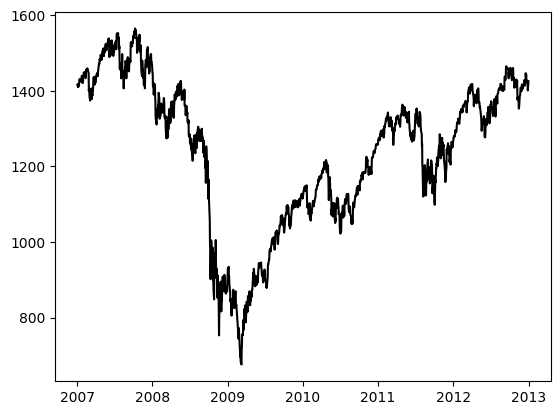

In [5]:
plt.figure
plt.plot(dataset[['calculation_date','spot_price']].drop_duplicates().set_index('calculation_date'),color='black')
plt.show()
unique_dates = dataset['calculation_date'].unique()

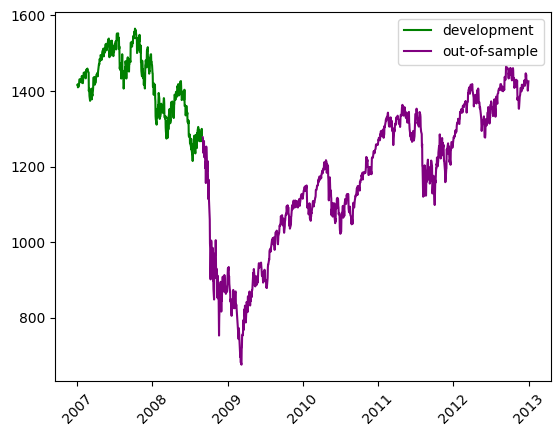

In [6]:
development_dates = unique_dates[unique_dates<=pd.Timestamp(2008,9,1)]
test_dates = unique_dates[~unique_dates.isin(development_dates)]
train_data = dataset[dataset['calculation_date'].isin(development_dates)]
test_data = dataset[dataset['calculation_date'].isin(test_dates)]
plt.figure()
plt.xticks(rotation=45)
plt.plot(train_data[['calculation_date','spot_price']].copy().drop_duplicates().set_index('calculation_date'),color='green',label='development')
plt.plot(test_data[['calculation_date','spot_price']].copy().drop_duplicates().set_index('calculation_date'),color='purple',label='out-of-sample')
plt.legend()
plt.show()

In [7]:
arrs = trainer.get_train_test_arrays(
    train_data, test_data)
preprocessor = trainer.preprocess()
train_X = arrs['train_X'] 
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['test_y']
trainer.solver = 'lbfgs'
trainer.__dict__

{'target_name': 'observed_price',
 'numerical_features': ['spot_price',
  'strike_price',
  'days_to_maturity',
  'risk_free_rate',
  'dividend_rate',
  'kappa',
  'theta',
  'rho',
  'eta',
  'v0',
  'fixing_frequency',
  'n_fixings',
  'past_fixings'],
 'categorical_features': ['averaging_type', 'w'],
 'feature_set': ['spot_price',
  'strike_price',
  'days_to_maturity',
  'risk_free_rate',
  'dividend_rate',
  'kappa',
  'theta',
  'rho',
  'eta',
  'v0',
  'fixing_frequency',
  'n_fixings',
  'past_fixings',
  'averaging_type',
  'w'],
 'random_state': None,
 'max_iter': 1000,
 'n_layers': None,
 'layer_size': 15,
 'hidden_layer_sizes': (15, 15, 15),
 'solver': 'lbfgs',
 'alpha': 0.0001,
 'learning_rate': 'adaptive',
 'activation_function': 'relu',
 'rf_n_estimators': 50,
 'rf_min_samples_leaf': 2000,
 'transformers': [('StandardScaler',
   StandardScaler(),
   ['spot_price',
    'strike_price',
    'days_to_maturity',
    'risk_free_rate',
    'dividend_rate',
    'kappa',
    'th

# Training

In [8]:
model_fit, runtime, specs = trainer.run_dnn(preprocessor,train_X,train_y)
train_end = time.time()
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")


training...

Deep Neural Network
hidden layers sizes: (15, 15, 15)
learning rate: adaptive
activation: relu
solver: lbfgs
alpha: 0.0001

cpu: 47.22897911071777


# Testing

In [9]:
model_fit

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                                                        'theta',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0',
                                                                                        'fixing_frequency',
                                                                                        'n_fixings',
                                                                                        'past_fixings']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['averaging_type',
                                                                                        'w'])])),
                                                     ('regressor',
                                                      MLPRegressor(hidden_layer_sizes=(15,
                                                                                       15,
                                                                                       15),
                                                                   learning_rate='adaptive',
                                                                   max_iter=1000,
                                                                   solver='lbfgs'))]),
                           transformer=Pipeline(steps=[('StandardScaler',
                                                        StandardScaler())]))

In [10]:
insample, outsample, errors = trainer.test_prediction_accuracy(
        model_fit,
        test_data,
        train_data
)
outofsample_RMSE = errors['outofsample_RMSE']


in sample:
     RMSE: 3.134330972247524
     MAE: 1.7997549337210537

out of sample:
     RMSE: 19.837266657523347
     MAE: 7.315262425750706


# Saving

In [11]:
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H-%M-%S"))
file_tag = str(train_end_tag + " " + specs[0] + " " + filetag)
os.chdir(os.path.join(notebook_dir,'trained_models'))
files_dir = os.path.join(
    notebook_dir,'trained_models','trained_models',
    file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    S = np.sort(train_data['spot_price'].unique())
    K = np.sort(train_data['strike_price'].unique())
    T = np.sort(train_data['days_to_maturity'].unique())
    W = np.sort(train_data['w'].unique())
    n_calls = train_data[train_data['w']=='call'].shape[0]
    n_puts = train_data[train_data['w']=='put'].shape[0]
    insample.to_csv(f"{file_dir} insample.csv")
    outsample.to_csv(f"{file_dir} outsample.csv")
    joblib.dump(model_fit,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    
    with open(f'{file_dir}.txt', 'w') as file:
        file.write(train_start_tag)
        file.write(f"\nspot(s):\n{S}")
        file.write(f"\n\nstrikes:\n{K}\n")
        file.write(f"\nmaturities:\n{T}\n")
        file.write(f"\ntypes:\n{W}\n")
        try:
            file.write(f"\n{train_data['barrier_type_name'].unique()}")
        except Exception:
            pass
        try:
            for col in ['averaging_type','fixing_frequency','past_fixings','n_fixings']:
                file.write(f"\n{col}:")
                file.write(f"\n{dataset[col].drop_duplicates().sort_values().values}\n")
        except Exception:
            pass
        file.write(f"\nnumber of calls, puts:\n{n_calls},{n_puts}\n")
        file.write(f"\ntotal prices:\n{train_data.shape[0]}\n")
        for spec in specs:
            file.write(f"{spec}\n")
        file.write("#"*17+"\n# training data #\n"+"#"*17+
              f"\n{train_data.describe()}\n")
        file.write("#"*13+"\n# test data #\n"+"#"*13+
              f"\n{test_data.describe()}\n")
        file.write(f"\n{dataset.dtypes}")
        file.write(
            f"\nin sample results:"
            f"\n     RMSE: {errors['insample_RMSE']}"
            f"\n     MAE: {errors['insample_MAE']}\n"
            f"\nout of sample results:"
            f"\n     RMSE: {errors['outofsample_RMSE']}"
            f"\n     MAE: {errors['outofsample_MAE']}\n"
            )
        file.write("\nfeatures:\n")
        for feature in trainer.feature_set:
            file.write(f"     {feature}\n")
        file.write(f"\ntarget: {trainer.target_name}\n")
        file.write(f"\ncpu: {train_runtime}\n")
        file.write(datetime.fromtimestamp(train_end).strftime('%c'))
        print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")

execute the command 'save_model()' to save the following model: 2024_10_27 08-05-24 Deep Neural Network asian options
